In [219]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch.optim as optim


NUM_ATTRIBUTES = 78

In [220]:
# data = pd.concat(map(pd.read_csv, ["Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", 
#                                  "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
#                                  "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
#                                  "Friday-WorkingHours-Morning.pcap_ISCX.csv",
#                                  "Monday-WorkingHours.pcap_ISCX.csv",
#                                  "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
#                                  "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
#                                  "Tuesday-WorkingHours.pcap_ISCX.csv",
#                                  "Wednesday-workingHours.pcap_ISCX.csv"]))
data = pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", header=None)

X = data.iloc[:, 0:NUM_ATTRIBUTES] # obtain all instances and there columns except the last column
y = data.iloc[:, NUM_ATTRIBUTES:] # obtain all instances and only the last column (label)

X = X.drop(0) #gets rid of the first row (features names)
y = y.drop(0) #gets rid of the first row (label name - Label)
print("TOTAL ROWS PARSED: ", len(X.values)) # prints the total num of instances 

X_VALUES = (X.values).astype('float32') # converts all numbers into floating point values 32

X_VALUES[np.isnan(X_VALUES)] = 0 #replaces all values of nan with 0
X_VALUES[np.isinf(X_VALUES)] = 0 #replaces all values of inf with 0

np.savetxt('test1.txt', X_VALUES, fmt='%d') 

C:\Users\14435\AppData\Local\Temp\ipykernel_2324\343768719.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", header=None)


286467
object


In [221]:
# Transforms the y outputs to be encoded
# encode all the possible labels an instance can have
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
print(ohe.categories_)
 
# transform the y labels to be a digestible list 
# ex.) ['BENIGN', 'PortScan'] => [1. 0.] (means the instance has the label of BENIGN)
y = ohe.transform(y)
print(y)
print(len(y[0]))
output_size = len(y[0])





[array(['BENIGN', 'PortScan'], dtype=object)]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
2


In [222]:
# architecture of the network
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_one = nn.Linear(78, 154) # seventy eight for all the input features and one hundred and fifty four for the expansion
        self.hidden_two = nn.Linear(154, 78) # another network layer
        self.act = nn.ReLU()
        self.output = nn.Linear(78, output_size) # output size is the appropriate y label
        
    def forward(self, x):
        x = self.act(self.hidden_one(x)) 
        x = self.act(self.hidden_two(x))
        x = self.output(x)
        return x
    
model = Multiclass()

Below is how you can define the loss metric. The CrossEntropyLoss function in PyTorch combines the softmax function with the cross entropy calculation, so you don’t need any activation function at the output layer of your model. You also need an optimizer, and Adam is chosen below.

In [223]:
# obtain the loss function we will use (used to determine how good our model preforms)
loss_fn = nn.CrossEntropyLoss()
# optimizer used to improve our model
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch 0: 100%|██████████| 2291/2291 [00:08<00:00, 274.95batch/s, acc=1, loss=-]         


Epoch 0 validation: Cross-entropy=1064.54, Accuracy=99.5%


Epoch 1: 100%|██████████| 2291/2291 [00:08<00:00, 275.80batch/s, acc=0.99, loss=0.133]  


Epoch 1 validation: Cross-entropy=222.55, Accuracy=99.2%


Epoch 2: 100%|██████████| 2291/2291 [00:08<00:00, 273.56batch/s, acc=0.85, loss=3.53]   


Epoch 2 validation: Cross-entropy=279.40, Accuracy=93.9%


Epoch 3: 100%|██████████| 2291/2291 [00:08<00:00, 269.95batch/s, acc=1, loss=-]         


Epoch 3 validation: Cross-entropy=178.69, Accuracy=96.1%


Epoch 4: 100%|██████████| 2291/2291 [00:08<00:00, 263.12batch/s, acc=1, loss=2.38e-9]   


Epoch 4 validation: Cross-entropy=369.83, Accuracy=99.4%


Epoch 5: 100%|██████████| 2291/2291 [00:08<00:00, 263.33batch/s, acc=1, loss=-]         


Epoch 5 validation: Cross-entropy=352.61, Accuracy=98.6%


Epoch 6: 100%|██████████| 2291/2291 [00:08<00:00, 262.32batch/s, acc=1, loss=-]         


Epoch 6 validation: Cross-entropy=117.06, Accuracy=99.5%


Epoch 7: 100%|██████████| 2291/2291 [00:08<00:00, 258.86batch/s, acc=1, loss=-]         


Epoch 7 validation: Cross-entropy=152.08, Accuracy=99.1%


Epoch 8: 100%|██████████| 2291/2291 [00:08<00:00, 259.73batch/s, acc=1, loss=-]         


Epoch 8 validation: Cross-entropy=54.52, Accuracy=99.5%


Epoch 9: 100%|██████████| 2291/2291 [00:08<00:00, 260.09batch/s, acc=1, loss=-]         


Epoch 9 validation: Cross-entropy=51.57, Accuracy=99.7%


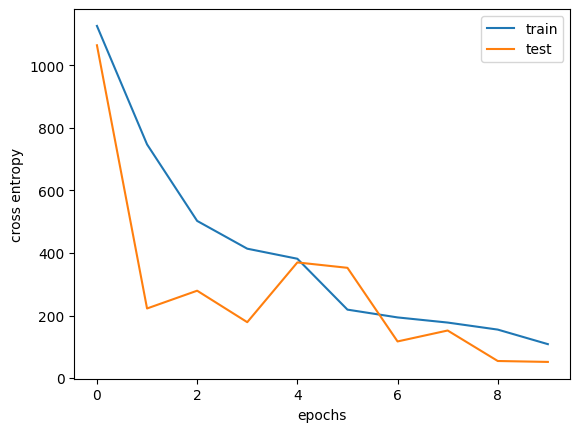

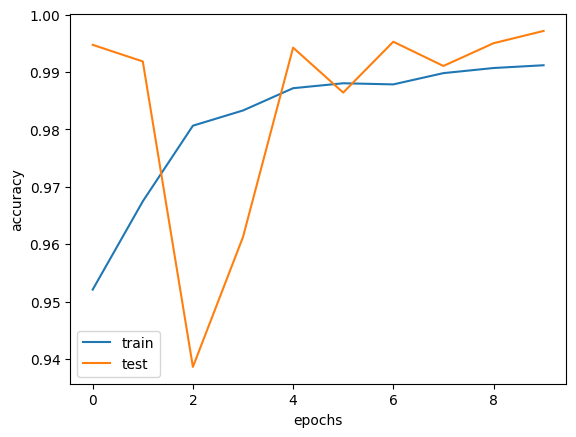

In [224]:

import tqdm
 
# convert pandas DataFrame features (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X_VALUES, dtype=torch.float32) # convert feature values into tensors
y = torch.tensor(y, dtype=torch.float32) # convert label values in tensors
 
#split the data into x training data (80% of feature data), x test data (20% of feature data), y training data (80% of label data),  y test data (20% of label data)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True) 

# prepare model and training parameters
n_epochs = 10 # number of times we iterate over the data
batch_size = 100 # number of samples processed before an update is preformed
batches_per_epoch = len(X_train) // batch_size
 
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
# training loop
for epoch in range(n_epochs):
    epoch_loss = [] # keeps track of the overall loss
    epoch_acc = [] # keeps track of the accuracy after each iteration on the training data
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
 
# Restore best model
model.load_state_dict(best_weights)
 
# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [225]:
# saves the model to PATH variable
PATH = './test_model.pth'
torch.save(model.state_dict(), PATH)

In [226]:
PATH = './test_model.pth'
model = Multiclass() # initialize your model class
model.load_state_dict(torch.load(PATH))

# convert pandas DataFrame features (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X_VALUES, dtype=torch.float32) # convert feature values into tensors
y = torch.tensor(y, dtype=torch.float32) # convert label values in tensors
 
#split the data into x training data (80% of feature data), x test data (20% of feature data), y training data (80% of label data),  y test data (20% of label data)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)


attack_test_count = 0
benign_test_count = 0

attack_array = []
index_array = []

for index, label in enumerate(y_test):
    benign_test_count += 1
    if False in torch.eq(torch.tensor([1., 0.]), label):
        index_array.append(index)
        attack_test_count += 1

print(index_array)
for index in index_array:
    y_pred = model(X_test[index])
    ce = loss_fn(y_pred, y_test[index])
    # acc = (torch.argmax(y_pred) == torch.argmax(y_test[index])).float().mean()
    # ce = float(ce)
    # acc = float(acc)
    print(torch.argmax(y_pred) == torch.argmax(y_test[index]))
    print(torch.argmax(y_pred))
    print(torch.argmax(y_test[index]))
    




C:\Users\14435\AppData\Local\Temp\ipykernel_2324\2251829542.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32) # convert label values in tensors


[0, 3, 5, 7, 8, 9, 12, 13, 14, 17, 18, 23, 24, 25, 26, 27, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 44, 48, 49, 50, 51, 53, 54, 55, 58, 60, 62, 63, 64, 66, 67, 68, 72, 75, 77, 78, 80, 81, 82, 83, 85, 86, 87, 90, 91, 96, 99, 100, 101, 103, 106, 107, 108, 109, 112, 113, 114, 116, 122, 123, 125, 126, 127, 128, 129, 130, 132, 134, 137, 138, 140, 142, 143, 144, 145, 146, 149, 152, 153, 155, 156, 157, 158, 160, 161, 162, 164, 165, 166, 168, 169, 173, 175, 176, 179, 180, 181, 183, 185, 186, 188, 189, 190, 191, 192, 194, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 210, 215, 216, 217, 219, 222, 227, 228, 230, 231, 233, 235, 236, 238, 241, 242, 245, 250, 251, 254, 256, 257, 258, 260, 261, 263, 264, 265, 266, 267, 268, 270, 271, 274, 275, 276, 277, 278, 280, 281, 284, 286, 287, 289, 290, 291, 294, 296, 297, 299, 300, 306, 307, 309, 313, 316, 319, 320, 322, 324, 325, 327, 328, 329, 330, 331, 333, 334, 335, 336, 338, 339, 341, 344, 347, 349, 351, 352, 353, 355, 356, 358, 361, 362, 364, 365, 36